In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import  Dense, Input, GlobalAveragePooling2D, Dropout, Flatten
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

2024-07-31 15:44:14.464967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 15:44:14.465082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 15:44:14.589428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
train_data=gen.flow_from_directory(directory='/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Training',
                                              class_mode='categorical',
                                              target_size=(128,128),
                                              batch_size=32,
                                              shuffle=True)

Found 6231 images belonging to 24 classes.


In [4]:
train_data.classes

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [5]:
train_data.class_indices

{'apple_6': 0,
 'apple_braeburn_1': 1,
 'apple_crimson_snow_1': 2,
 'apple_golden_1': 3,
 'apple_golden_2': 4,
 'apple_golden_3': 5,
 'apple_granny_smith_1': 6,
 'apple_hit_1': 7,
 'apple_pink_lady_1': 8,
 'apple_red_1': 9,
 'apple_red_2': 10,
 'apple_red_3': 11,
 'apple_red_delicios_1': 12,
 'apple_red_yellow_1': 13,
 'apple_rotten_1': 14,
 'cabbage_white_1': 15,
 'carrot_1': 16,
 'cucumber_1': 17,
 'cucumber_3': 18,
 'eggplant_violet_1': 19,
 'pear_1': 20,
 'pear_3': 21,
 'zucchini_1': 22,
 'zucchini_dark_1': 23}

In [6]:
train_data.image_shape

(128, 128, 3)

In [7]:
val_data=gen.flow_from_directory(directory='/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Validation',
                                              class_mode='categorical',
                                              target_size=(128,128),
                                              batch_size=32,
                                              shuffle=True
                                              )

Found 3114 images belonging to 24 classes.


In [8]:
test_data=gen.flow_from_directory(directory='/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test',
                                              class_mode='categorical',
                                              target_size=(128,128),
                                              batch_size=32,
                                              shuffle=False
                                              )

Found 3110 images belonging to 24 classes.


In [9]:
input_layer=Input(shape=(128,128,3))

In [10]:
vgg16=tf.keras.applications.VGG16(include_top=False,weights='imagenet', input_tensor=input_layer)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
for layer in vgg16.layers:
    layer.training=False
    print(layer, layer.training)

<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> False
<Conv2D name=block5_conv2, built=True> False
<Conv2D name=block5_conv3, built=True> False
<MaxPooling2D name=block5_pool, built=True> False


In [13]:
vgg16.output

<KerasTensor shape=(None, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_18>

In [14]:
output=vgg16.output
output=Flatten()(output)
output

<KerasTensor shape=(None, 8192), dtype=float32, sparse=False, name=keras_tensor_19>

In [15]:
output=Dense(units=4100,activation='relu')(output)
output=Dropout(0.2)(output)
output=Dense(units=24,activation='softmax')(output)


In [16]:
output

<KerasTensor shape=(None, 24), dtype=float32, sparse=False, name=keras_tensor_22>

In [17]:
input_layer

<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=None, name=keras_tensor>

In [18]:
model=Model(inputs=[input_layer], outputs=[output])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4100)           │    33,591,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4100)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        98,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,404,412 (184.65 MB)

 Trainable params: 48,404,412 (184.65 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
train_data.samples

6231

In [22]:
batch_size=64
steps_per_epoch=train_data.samples//batch_size 

validation_steps=val_data.samples//batch_size 

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',       
    patience=10,                
    restore_best_weights=True  
)

In [24]:
history=model.fit(train_data, epochs=50, steps_per_epoch=steps_per_epoch, 
                  validation_data=val_data, validation_steps=validation_steps, 
                  callbacks=[early_stopping] )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722440713.270319      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722440713.300083      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 7/97 ━━━━━━━━━━━━━━━━━━━━ 7:46 5s/step - accuracy: 0.0476 - loss: 24.9968  

W0000 00:00:1722440744.392468      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.0928 - loss: 7.5699

W0000 00:00:1722440766.923643      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 107s 672ms/step - accuracy: 0.0934 - loss: 7.5339 - val_accuracy: 0.3919 - val_loss: 1.8824
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.5833 - loss: 1.2566 - val_accuracy: 0.8451 - val_loss: 0.4118
Epoch 3/50
 1/97 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.8125 - loss: 0.4921

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8125 - loss: 0.4921 - val_accuracy: 0.8571 - val_loss: 0.2785
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.8358 - loss: 0.4604 - val_accuracy: 0.7832 - val_loss: 0.6438
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.8901 - loss: 0.3134 - val_accuracy: 0.8190 - val_loss: 0.7370
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7812 - loss: 0.7016 - val_accuracy: 0.6667 - val_loss: 1.0198
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.8789 - loss: 0.3709 - val_accuracy: 0.9473 - val_loss: 0.1320
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.9570 - loss: 0.1271 - val_accuracy: 0.9629 - val_loss: 0.1151
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.9688 - loss: 0.1018 - val_accuracy: 0.9762 - val_loss: 0.1498
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.9423 - loss: 0.1932 - val_accuracy: 0.9961 -

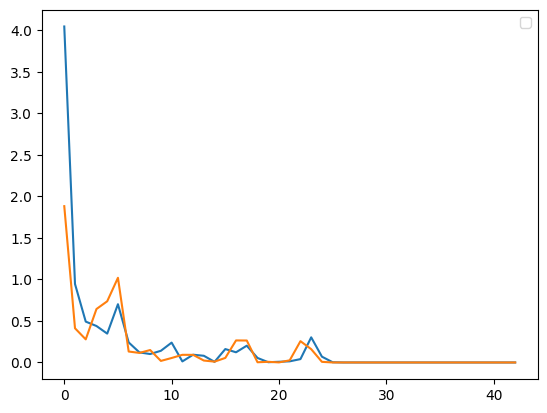

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend()

In [26]:
predictions=model.predict(test_data)
predictions

 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:21 845ms/step

W0000 00:00:1722441315.330615      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 35s 356ms/step


array([[9.99995470e-01, 8.53642286e-18, 6.41614413e-15, ...,
        1.59997331e-08, 2.25639752e-15, 1.21284183e-14],
       [9.99997735e-01, 2.02985143e-17, 4.49314810e-15, ...,
        4.48624249e-09, 2.27466420e-15, 3.66047787e-15],
       [1.00000000e+00, 5.56923369e-17, 2.21182834e-15, ...,
        8.01912009e-12, 1.04605045e-14, 1.94331857e-17],
       ...,
       [1.46174628e-21, 3.54228433e-20, 3.86475061e-17, ...,
        1.43828532e-10, 2.15252467e-19, 1.00000000e+00],
       [6.81525868e-20, 1.71880247e-19, 3.26245301e-16, ...,
        4.53267007e-10, 3.89946093e-18, 1.00000000e+00],
       [5.34800589e-22, 8.64207472e-23, 6.90225663e-19, ...,
        4.69343002e-11, 3.38107717e-20, 1.00000000e+00]], dtype=float32)

In [27]:
predictions_label=np.argmax(predictions,axis=1)
predictions_label

array([ 0,  0,  0, ..., 23, 23, 23])

In [28]:
test_data.classes

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [29]:
accuracy_score(test_data.classes,predictions_label)

1.0

In [30]:
test_data.class_indices

{'apple_6': 0,
 'apple_braeburn_1': 1,
 'apple_crimson_snow_1': 2,
 'apple_golden_1': 3,
 'apple_golden_2': 4,
 'apple_golden_3': 5,
 'apple_granny_smith_1': 6,
 'apple_hit_1': 7,
 'apple_pink_lady_1': 8,
 'apple_red_1': 9,
 'apple_red_2': 10,
 'apple_red_3': 11,
 'apple_red_delicios_1': 12,
 'apple_red_yellow_1': 13,
 'apple_rotten_1': 14,
 'cabbage_white_1': 15,
 'carrot_1': 16,
 'cucumber_1': 17,
 'cucumber_3': 18,
 'eggplant_violet_1': 19,
 'pear_1': 20,
 'pear_3': 21,
 'zucchini_1': 22,
 'zucchini_dark_1': 23}

In [31]:
labels=list(test_data.class_indices.keys())
labels

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_violet_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

In [32]:
images=test_data.filepaths
images

['/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_103.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_107.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_11.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_111.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_115.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_119.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_123.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_127.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_131.jpg',
 '/kaggle/input/fruits/fruits-360-original-size/fruits-360-original-size/Test/apple_6/r0_135.jpg',
 '/kaggle/i

Text(0.5, 1.0, 'real:cucumber_1\npredicted:cucumber_1')

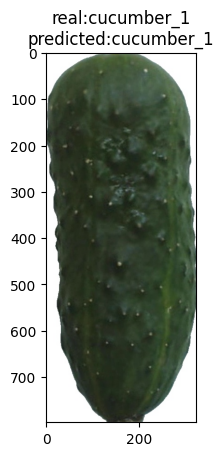

In [33]:
random=np.random.randint(0,3110)
image=cv2.imread(images[random])
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('real:'+labels[test_data.classes[random]]+
          '\n'+
          'predicted:'+labels[predictions_label[random]])